# LightGBM（特徴量：ALL）の学習→予測→評価

In [ ]:
# # Colabでバージョンを変更するとき、コメントアウトして実行してください
# !pip install pandas==1.5.3
# !pip install numpy==1.22.4
# !pip install matplotlib==3.7.1
# !pip install scikit-learn==1.2.2
# !pip install lightgbm==3.3.5
# !pip install shap==0.41.0

In [1]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# バージョンの確認
import matplotlib
import sklearn
import lightgbm as lgb
print(pd.__version__) 
print(np.__version__)
print(matplotlib.__version__)
print(sklearn.__version__) 
print(lgb.__version__)

1.5.3
1.22.4
3.7.1
1.2.2
3.3.5


In [3]:
# データセットの読み込み
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', header=None, sep='\s+')
df.columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
#df.head()

In [4]:
# 特徴量と目的変数の設定
X = df.drop(['MEDV'], axis=1)
y = df['MEDV']

In [5]:
# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)

X_trainの形状： (404, 13)  y_trainの形状： (404,)  X_testの形状： (102, 13)  y_testの形状： (102,)


In [6]:
# ハイパーパラメータの設定
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)

params = {'objective': 'mse',
          'num_leaves': 5,
          'seed': 0,
          'verbose': -1,
}

In [7]:
# モデルの学習
model = lgb.train(params,
                  lgb_train,
                  num_boost_round=50,
                  valid_sets=[lgb_train],
                  valid_names=['train'],
                  callbacks=[lgb.log_evaluation(10)])

[10]	train's l2: 23.2264
[20]	train's l2: 11.4353
[30]	train's l2: 8.26905
[40]	train's l2: 6.83309
[50]	train's l2: 5.88687


In [8]:
# 学習データの予測と評価
y_train_pred = model.predict(X_train) 
print('MSE train: %.2f' % (mean_squared_error(y_train, y_train_pred)))
print('RMSE train: %.2f' % (mean_squared_error(y_train, y_train_pred) ** 0.5))

MSE train: 5.89
RMSE train: 2.43


In [9]:
# テストデータの予測と評価
y_test_pred = model.predict(X_test)
print('RMSE test: %.2f' % (mean_squared_error(y_test, y_test_pred) ** 0.5))

RMSE test: 4.97


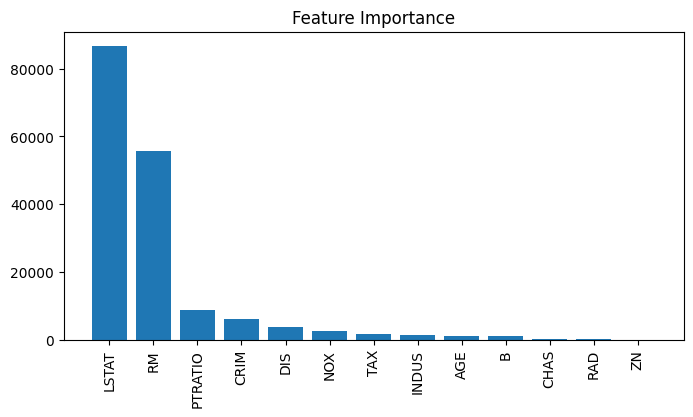

In [10]:
# 特徴量の重要度の可視化
importances = model.feature_importance(importance_type='gain') # 特徴量の重要度
indices = np.argsort(importances)[::-1] # 特徴量の重要度を降順にソート

plt.figure(figsize=(8, 4)) #プロットのサイズ指定
plt.title('Feature Importance') # プロットのタイトルを作成
plt.bar(range(len(indices)), importances[indices]) # 棒グラフを追加
plt.xticks(range(len(indices)), X.columns[indices], rotation=90) # X軸に特徴量の名前を追加
plt.show() # プロットを表示

<Axes: >

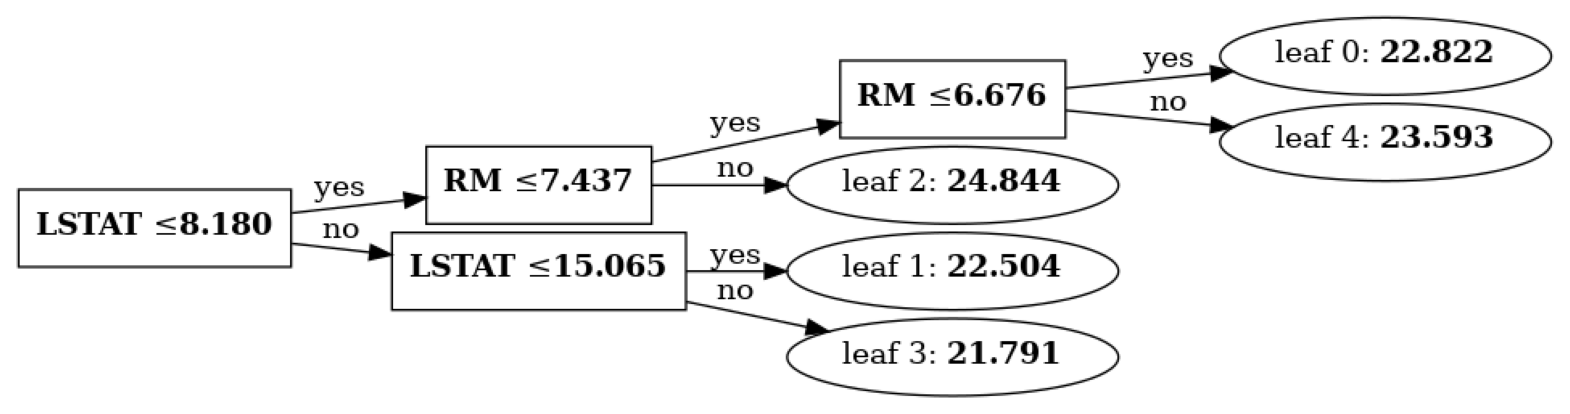

In [11]:
# 1本目の木の可視化
lgb.plot_tree(model, tree_index=0, figsize=(20, 20))

<Axes: >

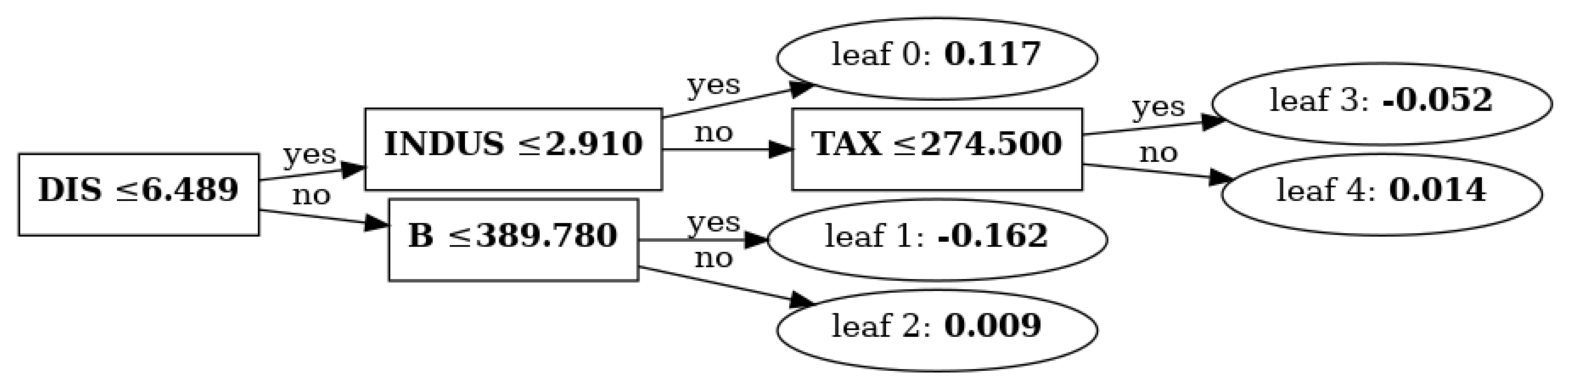

In [12]:
# 50本目の木の可視化
lgb.plot_tree(model, tree_index=-1, figsize=(20, 20))

# SHAP

In [13]:
# ライブラリshapのインストール
!pip install shap


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [14]:
import shap
shap.__version__

/home/takuya/.cache/pypoetry/virtualenvs/lightgbm-sample-qPUWcycm-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is not" with a literal. Did you mean "!="?
"is not" with a literal. Did you mean "!="?


'0.41.0'

In [15]:
# explainerの作成
import shap
explainer = shap.TreeExplainer(
    model = model,
    feature_perturbation = 'tree_path_dependent')

In [16]:
# # explainerの作成（interventional）
# import shap

# explainer = shap.TreeExplainer(
#     model = model,
#     data = X_test,
#     feature_perturbation = 'interventional')

In [17]:
# SHAP値の計算
shap_values = explainer(X_test)

In [18]:
# 全件レコードの期待値
explainer.expected_value

22.611881236511852

In [19]:
# 予測値のリスト
y_test_pred

array([24.33826347, 25.55850304, 22.88538477, 11.58613597, 22.02411837,
       20.72080442, 21.86359234, 21.10557067, 21.40360298, 19.23261144,
        9.61777349, 13.6106635 , 14.32141005,  9.76631897, 48.25601687,
       35.00875917, 21.95652073, 37.80759643, 25.87572833, 22.00650765,
       23.13945227, 22.36541355, 19.90861776, 23.78192781, 20.77748124,
       18.71856927, 19.06298637, 16.83366361, 42.81339824, 18.96547221,
       16.40352523, 16.24413082, 20.68783767, 20.67237901, 24.29716422,
       16.26813009,  9.76631897, 21.76083107, 16.2511962 , 15.31180178,
       22.50493327, 20.85719768, 23.72487685, 16.82037207, 23.63069676,
       22.69888006, 19.02106683, 16.85573098, 15.93691435, 23.13066412,
       18.16393601, 18.64008031, 21.32675084, 42.5370897 , 15.85521869,
       19.32749944, 20.24974385, 20.30964921, 18.99113574, 18.75245656,
       22.33068937, 20.77814028, 32.58636102, 31.77110891, 18.65418033,
       29.86652849, 15.53331969, 19.5093324 , 17.2016036 , 20.92

In [20]:
# 15件目のSHAP値
shap_values[14]

.values =
array([ 0.42917263,  0.        , -0.07889398,  0.2719192 ,  0.46275832,
       10.15551491,  0.38500326,  0.64666231,  0.11689572, -0.09221592,
        2.02745917,  0.20267821, 11.1171818 ])

.base_values =
22.611881236511852

.data =
array([  1.83377,   0.     ,  19.58   ,   1.     ,   0.605  ,   7.802  ,
        98.2    ,   2.0407 ,   5.     , 403.     ,  14.7    , 389.61   ,
         1.92   ])

In [21]:
# 15件目の貢献度
shap_values.values[14]

array([ 0.42917263,  0.        , -0.07889398,  0.2719192 ,  0.46275832,
       10.15551491,  0.38500326,  0.64666231,  0.11689572, -0.09221592,
        2.02745917,  0.20267821, 11.1171818 ])

In [22]:
# 15件目の貢献度合計
shap_values.values[14].sum()

25.644135635012184

In [23]:
# 期待値＋15件目の貢献度合計
shap_values[14].base_values + shap_values.values[14].sum()

48.25601687152404

In [24]:
# 15件目の予測値
y_test_pred[14]

48.25601687152407

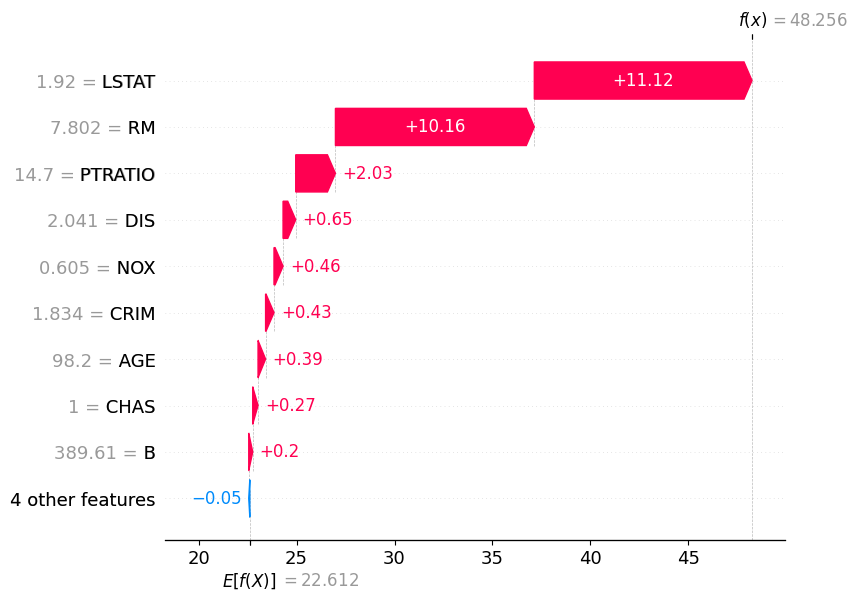

In [25]:
# 15件目のSHAP値の可視化
shap.plots.waterfall(shap_values[14])

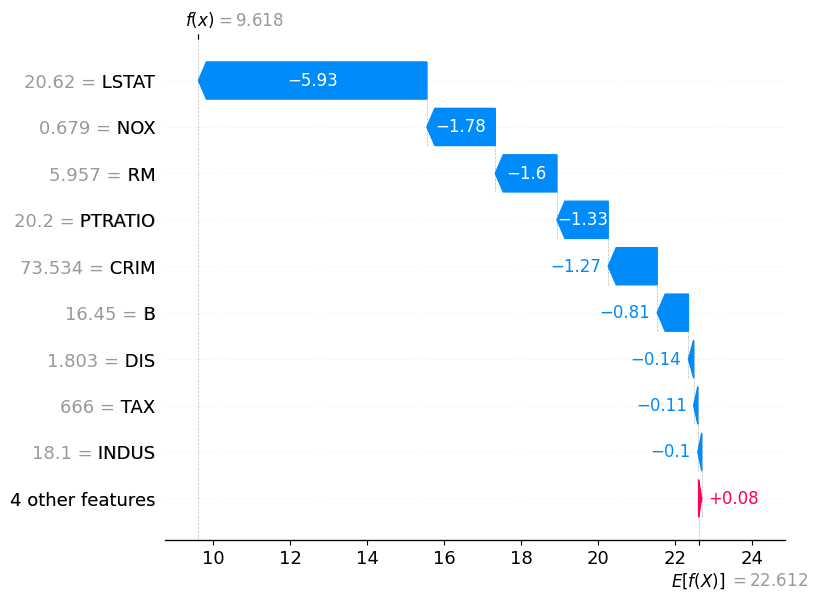

In [26]:
# 11件目のSHAP値の可視化
shap.plots.waterfall(shap_values[10])

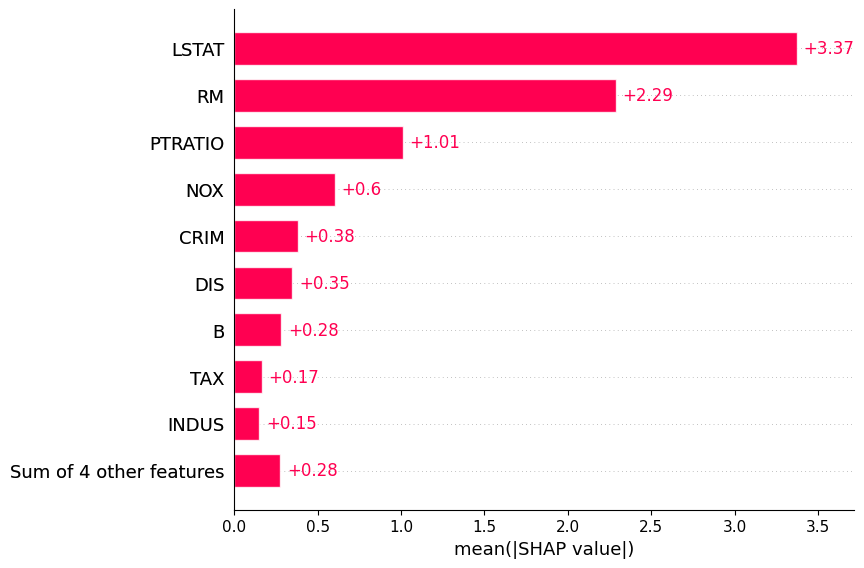

In [27]:
# 特徴量重要度の可視化
shap.plots.bar(shap_values=shap_values)